#  Directed Search: Uncertainty analysis

In this part the candidate solutions provide by the previous step are tested on their robustness level as this is preferred by our client, Rijkswaterstaat. Two metrics are applied to identify the level of robustness being; the Signal-to-Noise ratio and the Maximum regret value. The Signal-to_Noise ratio determines how strong the signal of a policy is in comparison to the background noise under different scenarios. In this case the signal can be seen as the preferred outcomes while the noise would indicate the various external effects and unintended consequences. Maximum regret relates to the maximum amount of regret that is created when a policy in a new scenario is compared to a reference scenario. The outcome of this metric is preferred to be as low as possible.

In the second step of MORDM outcomes and experiments were created by running 9 policies over 5000 scenarios.
The results of this step are framed in 2 csv files which will be used as input for this step.

Description of the uncertainty analysis can be found in chapter 3.2.3 in the report.

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, SequentialEvaluator, Policy)
from ema_workbench.analysis import parcoords

# Import the dike_model
from problem_formulation import get_model_for_problem_formulation

# Define model
dike_model, planning_steps = get_model_for_problem_formulation(2)

C:\Users\Kas\OneDrive - Delft University of Technology\Documenten\GitHub\Model-based-Decision-making\venv\Lib\site-packages\ema_workbench\em_framework\evaluators.py:58: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
C:\Users\Kas\OneDrive - Delft University of Technology\Documenten\GitHub\Model-based-Decision-making\venv\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


ModuleNotFoundError: No module named 'networkx'

In [ ]:
policies = pd.read_csv('data/output_data/MOEA_selected_policies.csv')
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [3]:
#Import of the csv files from the previous MORDM step
uncertainty_outcomes = pd.read_csv('data/output_data/MOEA_uncertainty_outcomes.csv')
uncertainty_experiments = pd.read_csv('data/output_data/MOEA_uncertainty_experiments.csv')

In [4]:
#uncertainty_outcomes = uncertainty_outcomes.drop(columns='Unnamed: 0')
uncertainty_outcomes

,Unnamed: 0,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,policy
0,0,2.905471e+06,5.915904e+08,151900000.0,297.737877,0.000271,0
1,1,0.000000e+00,5.915904e+08,151900000.0,0.000000,0.000000,0
2,2,4.675528e+05,5.915904e+08,151900000.0,43.651835,0.000048,0
3,3,0.000000e+00,5.915904e+08,151900000.0,0.000000,0.000000,0
4,4,1.251384e+07,5.915904e+08,151900000.0,898.634622,0.000688,0
...,...,...,...,...,...,...,...
49995,49995,0.000000e+00,4.853358e+08,182600000.0,0.000000,0.000000,4
49996,49996,0.000000e+00,4.853358e+08,182600000.0,0.000000,0.000000,4
49997,49997,0.000000e+00,4.853358e+08,182600000.0,0.000000,0.000000,4
49998,49998,0.000000e+00,4.853358e+08,182600000.0,0.000000,0.000000,4


In [5]:
uncertainty_experiments

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,0,73,237.223619,10.0,0.822949,257.939688,1.0,0.503687,191.079508,10.0,...,7,3,4,2,10,3,3,0,0,dikesnet
1,1,100,217.582195,1.0,0.605151,247.388211,1.0,0.312620,53.665794,1.0,...,7,3,4,2,10,3,3,1,0,dikesnet
2,2,102,330.365728,10.0,0.536505,199.599995,10.0,0.796105,290.208831,1.5,...,7,3,4,2,10,3,3,2,0,dikesnet
3,3,38,198.899576,10.0,0.863812,67.180982,1.0,0.254501,199.763387,1.0,...,7,3,4,2,10,3,3,3,0,dikesnet
4,4,95,259.903908,1.5,0.430111,116.302986,1.5,0.715382,258.385764,1.0,...,7,3,4,2,10,3,3,4,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,25,333.392351,1.5,0.182541,200.358237,10.0,0.491426,181.191046,10.0,...,0,6,3,5,10,0,0,9995,4,dikesnet
49996,49996,36,83.039895,1.0,0.946074,49.079330,1.5,0.391886,226.166062,1.5,...,0,6,3,5,10,0,0,9996,4,dikesnet
49997,49997,35,331.179930,1.0,0.183885,123.736414,10.0,0.144689,104.541520,1.5,...,0,6,3,5,10,0,0,9997,4,dikesnet
49998,49998,42,223.895330,1.0,0.887494,211.866952,1.0,0.594167,331.685061,10.0,...,0,6,3,5,10,0,0,9998,4,dikesnet


## 1. Signal-to-noise ratio

The Signal-to-noise ratio is executed in three steps. First the definition on how to calculate the Signal-to-noise ratio is given. Next, the Signal-to noise ratio is calculated for every unique policy of which the data is stored in the correct data frame form. Lastly, this data is used to determine the limits of the results and to visualize the outcomes.

In the first step the calculation on how to determine the Signal-to-noise ratio is formed. Depending on direction of the preferred outcome the Signal-to-noise ratio is either the mean divided by the standard deviation or the mean multiplied by the standard deviation. The preference of the outcome objectives dictates whether Signal-to-noise ratio is desired to be maximized or minimized. In this case it is favored that the outcomes of the objectives are as low as possible. Therefore, the focus will lie on a minimized Signal-to-noise ratio.


In [6]:
#Definition is created on how to calculate the Signal-to-Noise ratio
data = uncertainty_outcomes.loc[:,[o.name for o in dike_model.outcomes]]

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

#The Signal-to-noise ratio is calculated based upon the direction of each policy.
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

The second step in the process executes the defined method of calculating the Signal-to-Noise ratio and saves the data in a new dataframe. First, the code iterates over every unique policy in the experiments. The next iteration is on the outcomes in which the outcome is pulled for the current policy. These outcomes are used to calculate the Signal-to-noise ratio by utilizing the definition in the previous cell. In the last step these Signal-to-noise results are stored in the "scores" dictionary and later added to the "overall-scores" dictionary. Finally these results are converted to a data frame and used in the next step.

In [7]:
overall_scores = {}

for policy in np.unique(uncertainty_experiments['policy']):
    scores = {}

    logical = uncertainty_experiments['policy']==policy

    for outcome in dike_model.outcomes:
        value  = uncertainty_outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,2.758945e+16,70.523070,0.0,4.374158e+06,0.000190
1,2.982867e+15,46.705509,0.0,7.586682e+05,0.000021
2,1.215021e+15,26.212740,0.0,4.338612e+05,0.000011
3,7.568295e+14,0.000000,0.0,6.140729e+04,0.000052
4,9.402667e+15,57.856532,0.0,9.454624e+05,0.000103


The final step of the Signal-to-noise calculation focuses on the visualization of the results. For this purpose the parcoords method is used and imported from the EMA workbench. As a first step the scores data frame is renamed to "data". In a next step the limits of the results for each column are determined and the lower bound of the results is set to zero. Then the data with the limits is plotted using the parcoords method. The axis of the expected annual damage is inverted to visualize the limits for this outcome.

In [1]:
from ema_workbench.analysis import parcoords

#The data frame is renamed and the result limits are determined for the visualization.
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']] = 0

#The data is being plotted in a paracoords graph
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#Swapped axis eruit
#paraxes.invert_axis('Expected Annual Damage')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'ema_workbench'

The figure above indicates that none of the 5 policies are robust relating to the preferred objectives. In the ideal case all the coloured lines would cross the vertical lines on the lowest point which would indicate a low Signal-to-noise ratio.

As none of all the lines relate to the preferred case trade-offs between the outcomes have to be made. It is seen that for all policies the Room for River (RfR) investment is zero. This is because the RfR investment is a decision variable that is independent of external uncertainties. This indicates that this variable can influence the other variables while remaining unaffected by other variables.



and the same can be said for most policies relating to the Dike investment cost. However, there is a clear trade-off seen in the other objectives. For example whenever a policy has high evacuation costs, the expected number of death will be lower.


## 2. Maximum regret

The maximum regret value provides another metric to determine the robustness of a policy. First the regret for each single policy needs to be tested under each scenario. The definition of regret is the difference in performance of a policy between a specific scenario and a reference scenario. The maximum height of this regret is than named as the maximum regret and is preferred to be as low as possible.

KLOPT NIET MEER
As we are dealing with outcomes that are preferred to be maximized and minimized, the regret values will not align and will lead to undesirable results. To fix this the absolute value is taken for the regret values so that it is possible to compare the results.


The crucial part of the maximum regret approach is the identification of the best possible outcome for each scenario. To ensure this the following steps were taken in the code.
1. Two empty dictionaries are created to capture both the overall regret of the policies and the maximum regret.
2. The creation of a dataframe that consists out of the outcome together with the policy and the scenario.
3. The dataframe is reshaped by indexing on the policy and the scenario id
4. Here the maximum value of each row is taken and applied to calculate the regret.
5. Lastly, all the regret results are converted into a dictionary. Moreover, the maximum regret is selected from these results and converted into a separate dictionary.

In [10]:
def calculate_regret(data,best):
    return np.abs(best-data)

In [11]:
overall_regret = {}
max_regret = {}

for outcome in dike_model.outcomes:
    policy_column = uncertainty_experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: uncertainty_outcomes[outcome.name],
                         "policy":uncertainty_experiments['policy'],
                         "scenario":uncertainty_experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

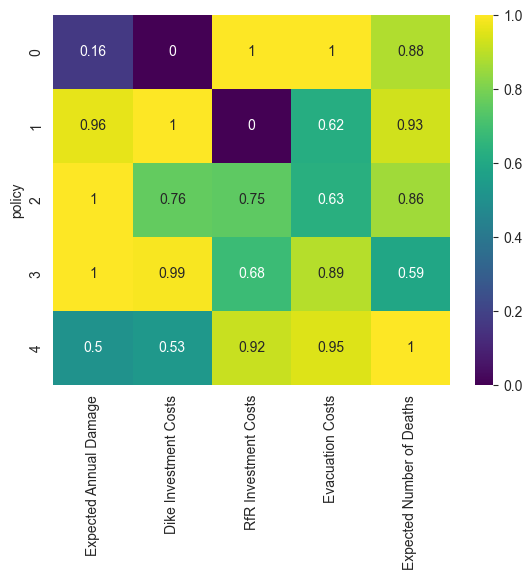

In [12]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [13]:
max_regret

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
0,2.920225e+08,0.000000e+00,363800000.0,23100.567869,0.195621
1,1.710144e+09,1.997962e+08,0.0,14270.143157,0.206282
2,1.772835e+09,1.518136e+08,273300000.0,14586.968589,0.190598
3,1.769864e+09,1.981846e+08,248500000.0,20488.311857,0.131017
4,8.948345e+08,1.062546e+08,333100000.0,21847.849394,0.221994


The heatmap above illustrates the relation between the policies and the objectives in terms of maximum regret. As mentioned before the favored results are as low as possible meaning that the maximum regret for a policy is little. From this image it is visible that policy 0 and policy 7 preform the worst while looking at all the objectives. What is interesting to see is that except for policy 8, all policies score really bad on evacuation costs.